In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.0 MB/s 
     |████████████████████████████████| 209 kB 77.2 MB/s 
     |████████████████████████████████| 81 kB 10.6 MB/s 
     |████████████████████████████████| 78 kB 8.3 MB/s 
     |████████████████████████████████| 112 kB 82.7 MB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 
     |████████████████████████████████| 147 kB 79.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=fe6272b0544b8f55c9523a3c9588fe94856ac1688afbf0f966128db5bded0ea6
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
import numpy as np
import pandas as pd

import optuna
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/MyDrive/ECE 570/train (1).csv')

In [6]:
print("The number of missing value")
train.isnull().sum() 

The number of missing value


id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [7]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']

    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    #df['u_in_lag'] = df['u_in'].shift(2).fillna(0)
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R']+df['C']
    df = pd.get_dummies(df)
    return df

train = add_features(train)

In [8]:
print(train.head())

   id  breath_id  time_step       u_in  u_out   pressure      area  cross  \
0   1          1   0.000000   0.083334      0   5.837492  0.000000    0.0   
1   2          1   0.033652  18.383041      0   5.907794  0.618632    0.0   
2   3          1   0.067514  22.509278      0   7.876254  2.138333    0.0   
3   4          1   0.101542  22.808822      0  11.742872  4.454391    0.0   
4   5          1   0.135756  25.355850      0  12.234987  7.896588    0.0   

   cross2  u_in_cumsum  ...  C_50  RC_2010  RC_2020  RC_2050  RC_5010  \
0     0.0     0.083334  ...     1        0        0        1        0   
1     0.0    18.466375  ...     1        0        0        1        0   
2     0.0    40.975653  ...     1        0        0        1        0   
3     0.0    63.784476  ...     1        0        0        1        0   
4     0.0    89.140326  ...     1        0        0        1        0   

   RC_5020  RC_5050  RC_510  RC_520  RC_550  
0        0        0       0       0       0  
1     

In [9]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1, inplace=True)

In [10]:
RS = RobustScaler()
train = RS.fit_transform(train)


In [11]:
train = train.reshape(-1, 80, train.shape[-1])


In [12]:
import tensorflow as tf
import os
import tensorflow_datasets as tfds

In [13]:
#Function to get hardware strategy
def get_hardware_strategy():
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.config.optimizer.set_jit(True)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    return tpu, strategy

tpu, strategy = get_hardware_strategy()

Running on TPU  grpc://10.18.61.226:8470


In [14]:
import time
start_time = time.time()
EPOCH = 3
BATCH_SIZE = 512

# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
start_time = time.time()
with strategy.scope():
    kf = KFold(n_splits=5, shuffle=True, random_state=1111)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        model = keras.models.Sequential([
            keras.layers.Input(shape=train.shape[-2:]),
            keras.layers.Bidirectional(keras.layers.LSTM(300, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(220, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(150, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)),
            keras.layers.Dense(50, activation='selu'),
            keras.layers.Dense(1),
        ])
        history = model.compile(optimizer="adam", loss="mae")

        scheduler = ExponentialDecay(1e-3, 400*((len(train)*0.8)/BATCH_SIZE), 1e-5)
        lr = LearningRateScheduler(scheduler, verbose=1)

        #es = EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min", restore_best_weights=True)

        history =model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr])
end_time = time.time()

--------------- > Fold 1 < ---------------

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/3
118/118 [==============================] - 58s 310ms/step - loss: 2.1296 - val_loss: 1.1149 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009997559245675802.
Epoch 2/3
118/118 [==============================] - 21s 179ms/step - loss: 0.8979 - val_loss: 0.7385 - lr: 9.9976e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000999511918053031.
Epoch 3/3
118/118 [==============================] - 21s 179ms/step - loss: 0.7135 - val_loss: 0.7041 - lr: 9.9951e-04
--------------- > Fold 2 < ---------------

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/3
118/118 [==============================] - 58s 313ms/step - loss: 2.2564 - val_loss: 1.0958 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009997559245675802.
Epoch 2/3
118/118 [============================

[1. 2. 3.]


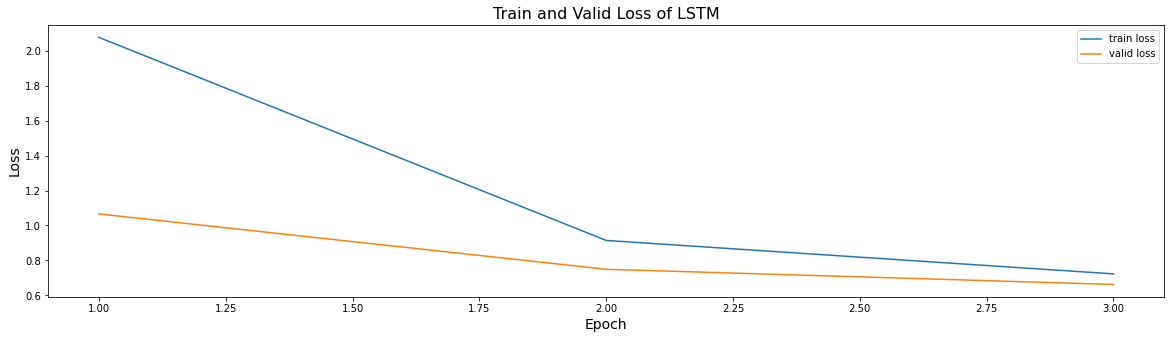

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
val = history.history['val_loss']
trn = history.history['loss']
x = np.linspace(1,EPOCH,EPOCH)
print(x)
plt.plot(x,trn,label='train loss')
plt.plot(x,val,label='valid loss')
plt.xlabel('Epoch',size=14)
plt.ylabel('Loss',size=14)
plt.title('Train and Valid Loss of LSTM',size=16)
plt.legend()
plt.show()

In [16]:
y_pred = model.predict(X_valid)

472/472 [==============================] - 17s 29ms/step


In [17]:
print(y_pred.shape)

(15090, 80, 1)


In [18]:
print(y_valid.shape)

(15090, 80)


In [19]:
def draw_result(start_id, end_id, target, y_pred):
  start_id1 = start_id -1
  end_id1 = end_id + 1  
  plt.figure(figsize = (20, 7))
  plt.plot(target[start_id1: end_id1,:].reshape(-1,1), linewidth=5, label = "actual Pressure values")
  plt.plot(y_pred[start_id1: end_id1,:].reshape(-1,1), linewidth=2, label = "predict Pressure values")
  plt.xlabel("Times")
  plt.ylabel("Pressure")
  plt.title(f"LSTM test_{start_id}_id--test_{end_id}_id")
  plt.legend()

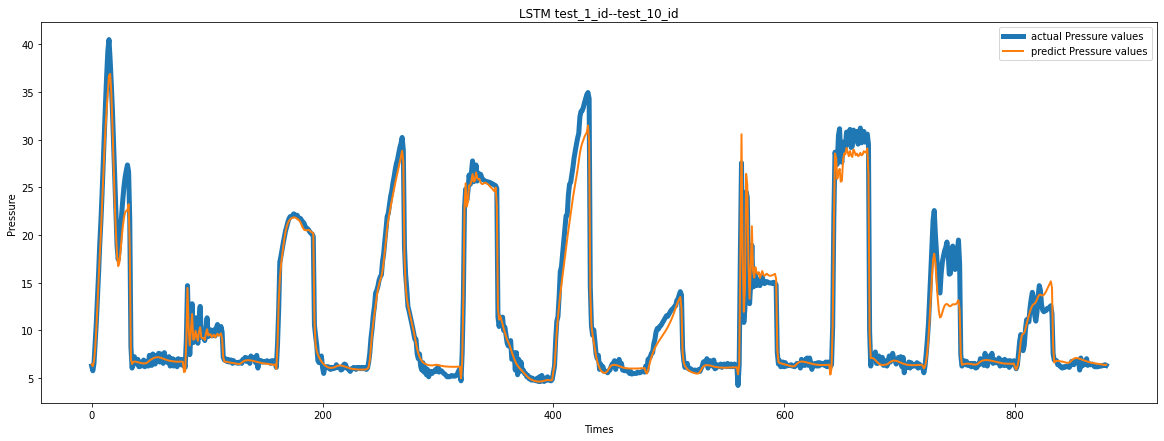

In [20]:
draw_result( 1,10, y_valid, y_pred)

In [21]:
cost_time = end_time - start_time
print(f"Time for Training model:%.2f s"%cost_time)

Time for Training model:560.45 s


In [22]:
from sklearn.metrics import r2_score
y_v = y_valid
y_p = y_pred.squeeze()
print(y_p.shape)
R_square = r2_score(y_v,y_p)
print("R^2 of the RNN model is:",R_square)

(15090, 80)
R^2 of the RNN model is: 0.8593356756656518
